In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

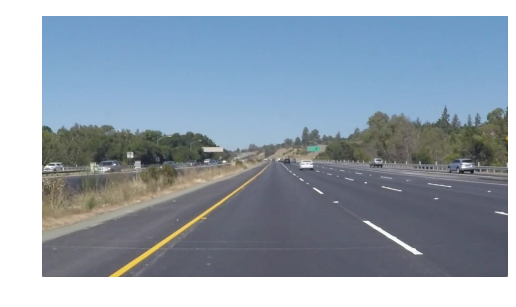

In [234]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.axis('off');

In [235]:
kernel_size = 5
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):

    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [236]:
image_ud = undistort_image(image, mtx_camera , dist_camera )

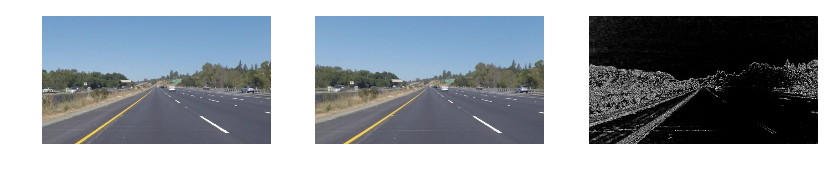

In [237]:
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.axis('off');

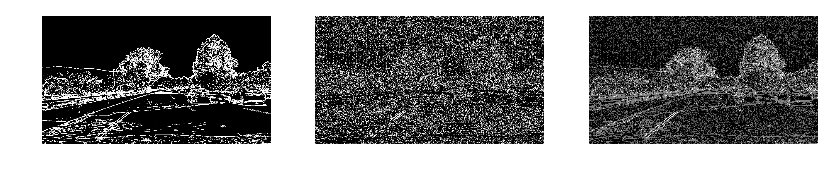

In [238]:
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(img_g_mag,cmap='gray')
plt.axis('off');
plt.subplot(1,3,2)
plt.axis('off');plt.imshow(img_d_mag,cmap='gray')

plt.subplot(1,3,3)
plt.imshow(img_g_mag+img_d_mag,cmap='gray')
plt.axis('off');

In [239]:
def sobel_combined(image):
    

    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

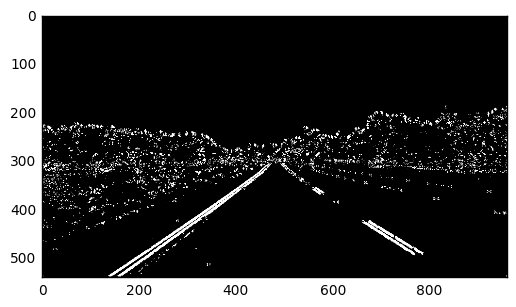

In [240]:
image = gaussian_blur(image, kernel=5)
img_gs = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
plt.imshow(sobel_c,cmap='gray')

In [241]:
np.shape(image)

(540, 960, 3)

In [254]:
src = np.float32([[110,540],[890,540],[510,320],[450,320]])
dst = np.float32([[100,540],[960,540],[960,0],[100,0]])

warped = warp_image(image,src,dst)

In [255]:
image.shape

(540, 960, 3)

(-200.0, 1000.0, 600.0, -100.0)

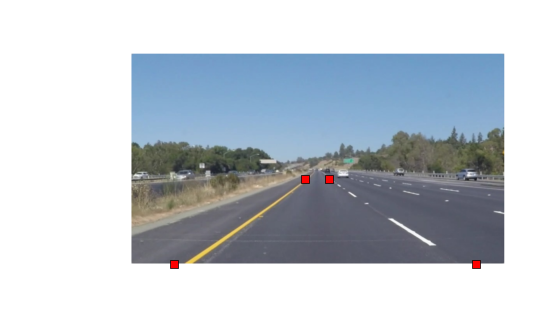

In [256]:
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.axis('off')


(-200.0, 1000.0, 600.0, -100.0)

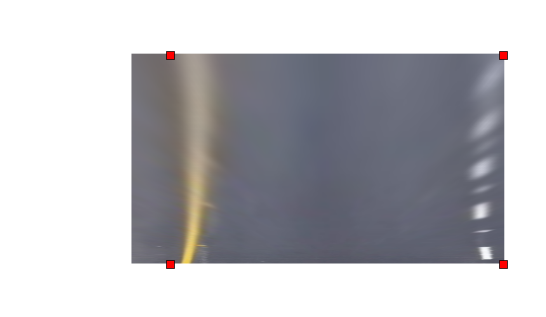

In [257]:
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
plt.axis('off')


In [70]:
image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)


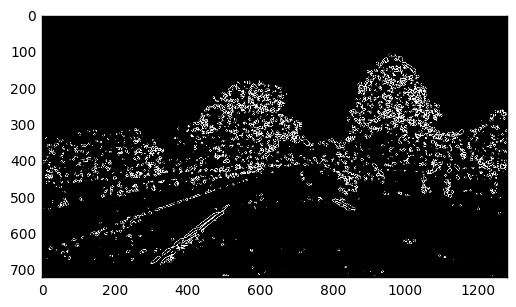

In [90]:
sobel_c = 255*sobel_combined(image_HLS[:,:,1])
plt.imshow(255-GaussianC_Adaptive_Threshold(np.uint8(sobel_c),11,50),cmap='gray')

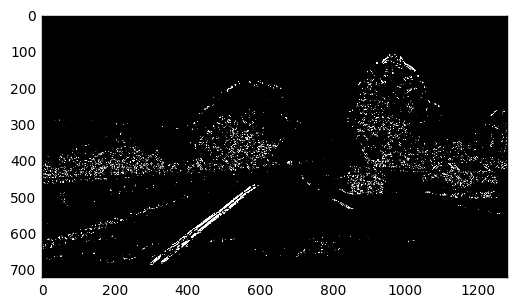

In [63]:
sobel_c = sobel_combined(image_HLS[:,:,2])
plt.imshow(sobel_c,cmap='gray')

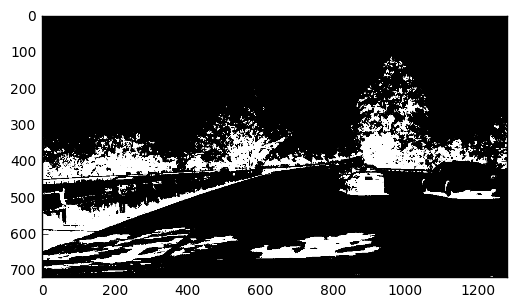

In [14]:
L_binary = np.zeros_like(image_L)
L_binary[(image_L>=0) & (image_L<=50)] = 1
L_binary = L_binary
plt.imshow(L_binary,cmap='gray')

In [15]:
def apply_mask(img,L_binary,val):
    condn = L_binary==1
    img[condn] = img[condn]+val
    img = ga
    return img

In [52]:
image_mask=np.copy(image_L)
image_mask = apply_mask(image_L,L_binary,100)
plt.imshow(image_mask,cmap='gray')

NameError: name 'ga' is not defined

In [53]:
image_HLS[:,:,1] = image_mask
image_RGB2 = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB)

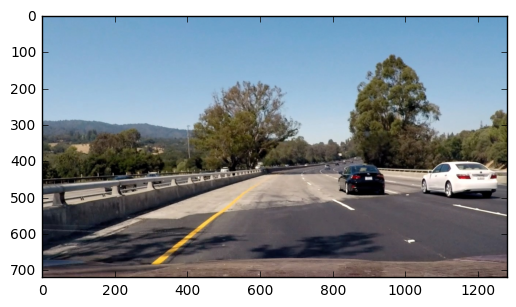

In [54]:
plt.imshow(image,cmap='gray')


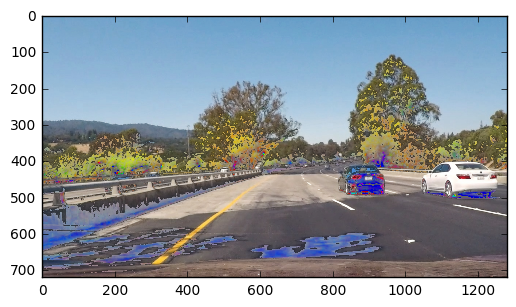

In [55]:
plt.imshow(image_RGB2,cmap='gray')

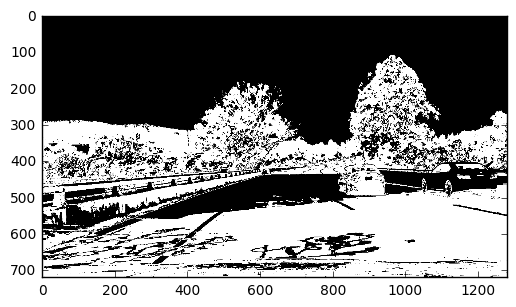

In [56]:
image_L = np.copy(image_HLS[:,:,1])
L_binary = image_L
L_binary = np.zeros_like(image_L)
L_binary[(image_L>=0) & (image_L<=128)] = 1
plt.imshow(L_binary,cmap='gray')

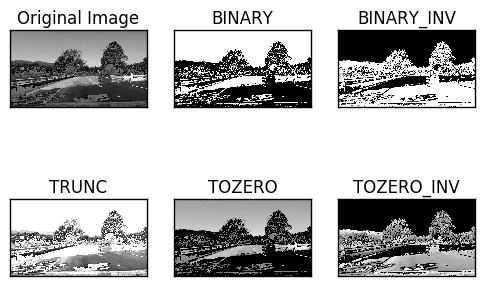

In [57]:
img = np.copy(image_L)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


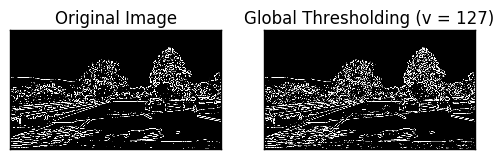

In [58]:
img = cv2.medianBlur(image_L,5)
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,10)

th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,4)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [255-th2, 255-th3]
for i in range(2):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


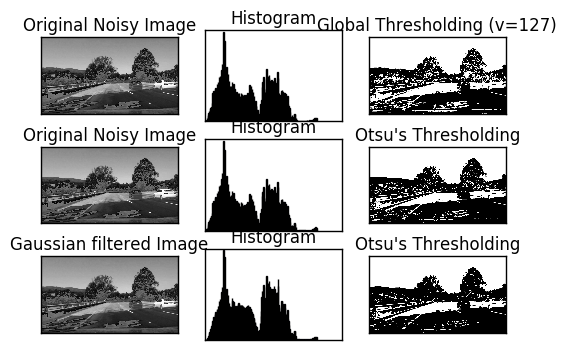

In [59]:
# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [60]:
blur = cv2.GaussianBlur(img,(5,5),0)
# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([blur],[0],None,[256],[0,256])
hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()
bins = np.arange(256)
fn_min = np.inf
thresh = -1
for i in range(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights
    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i
# find otsu's threshold value with OpenCV function
ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(thresh,ret)

137 136.0


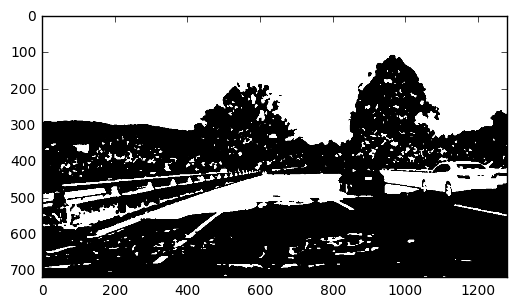

In [61]:
plt.imshow(otsu,cmap='gray')